In [1]:
"""
Train MetaDSP Model with split windows.
"""

import pickle, torch, numpy as np, time, argparse, os , yaml, jax
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
from functools import partial
from torch.utils.data import DataLoader, ConcatDataset
from torch.utils.tensorboard.writer import SummaryWriter
from src.TorchDSP.core import TorchInput, TorchSignal, TorchTime
from src.TorchDSP.dsp import DSP, LDBP, downsamp, ADF, TestDBP
from src.TorchDSP.train_dbp import Test, Train, DDLMS_jax
from src.TorchDSP.dataloader import  MyDataset
from src.TorchDSP.loss import BER_well, MSE, SNR, Qsq
from src.TorchSimulation.receiver import  BER
from src.JaxSimulation.dsp import BPS, bps, ddpll, cpr, mimoaf
import src.JaxSimulation.adaptive_filter as af
from src.JaxSimulation.core import MySignal, SigTime

test_data = MyDataset('dataset_A800/test.h5',  Nch=[21], Rs=[80], Pch=[2], Nmodes=2,
                        window_size=100000, strides=1, Nwindow=2, truncate=0,
                        Tx_window=True, pre_transform='Rx_DBP32')
test_loader = DataLoader(test_data, batch_size=2, shuffle=False, drop_last=True)

for Rx, Tx, info in test_loader:
    print(Rx.shape, Tx.shape, info.shape)
    break

Import Time: 2.11s
torch.Size([2, 200000, 2]) torch.Size([2, 100000, 2]) torch.Size([2, 4])


In [5]:
sig_in=jax.numpy.array(Rx)
symb_in = jax.numpy.array(Tx)
z = jax.vmap(DDLMS_jax, in_axes=(0,0,None,None))(sig_in, symb_in, 64, 2)
sig_out = torch.from_numpy(jax.device_get(z.val))

/tmp/ipykernel_2180408/1267113285.py:4: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  sig_out = torch.from_numpy(jax.device_get(z.val))


In [4]:
jax.device_z.val

Array([[[ 0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j],
        [ 1.4858642e-03-2.2879179e-04j, -3.8868931e-04-5.4858724e-04j],
        [ 2.0189714e-03+2.1580637e-04j, -5.3356332e-04-8.1300439e-04j],
        ...,
        [-3.5492224e-01-9.6667565e-02j,  9.7261703e-01-8.5209876e-01j],
        [ 8.3535540e-01-8.8205040e-01j, -1.1125567e+00+2.3695160e-01j],
        [-4.4761956e-01+9.6315318e-01j,  1.1024659e+00+5.5755270e-01j]],

       [[ 0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j],
        [ 1.4613436e-03+1.0124422e-03j, -3.8204913e-04-6.9724565e-04j],
        [-1.0158826e-03-1.2361321e-04j, -1.1108479e-03-2.1978952e-03j],
        ...,
        [ 8.3531785e-01-8.8204718e-01j, -1.1125615e+00+2.3695669e-01j],
        [-4.4759697e-01+9.6313149e-01j,  1.1024660e+00+5.5753547e-01j],
        [-9.2727703e-01-4.0691853e-01j, -5.6989312e-02+4.0973237e-01j]]],      dtype=complex64)

In [3]:
BER(sig_out[1][20000:], Tx[1,z.t.start:z.t.stop][20000:])

{'BER': array([0.00222899, 0.0023853 ], dtype=float32),
 'SER': array([0.00887844, 0.00952869], dtype=float32),
 'Qsq': array([9.077965, 9.011538], dtype=float32),
 'SNR': array([15.735983, 15.721802], dtype=float32)}

## Training

In [7]:
with open('configs/metadsp/metadbp.yaml') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

net = LDBP(cfg['model_info']['DBP_info']).to(cfg['device'])
conv = downsamp(taps=64, Nmodes=2, sps=2, init='zeros').to(cfg['device'])
optimizer = torch.optim.Adam([{'params': net.parameters(), 'lr': 3e-3}, {'params': conv.parameters(), 'lr': 3e-3}])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Concat data loader

Nwindow = 10000
Nch = 21 
Rs = 80
Pch = 2

train_datas = []
for nch in [Nch]:
    for rs in [Rs]:
        for pch in [Pch]:
            train_datas.append(MyDataset(cfg['train_path'], Nch=[nch], Rs=[rs], Pch=[pch], Nmodes=2,
                            window_size=cfg['tbpl'] + net.overlaps + conv.overlaps, strides=cfg['tbpl'], Nwindow=Nwindow, truncate=0,
                            Tx_window=True, pre_transform='Rx'))
dataset = ConcatDataset(train_datas)
train_loader = DataLoader(dataset, batch_size=10, shuffle=True, drop_last=True)
print(len(train_loader))

test_info = {'Pch': Pch, 'Rs': Rs, 'Nch': Nch}

log_path = f'_outputs/log_tensorboard/NewDBP/{Rs}G_{Nch}ch'
model_path = f'_models/NewDBP/{Rs}G_{Nch}ch'
Train(net, conv, train_loader, optimizer, scheduler, log_path, model_path, epoch_init=0, epochs=30, test_info=test_info, save_log=True, save_model=True, save_interval=1, device=cfg['device'])

# kernel = net.task_mlp.parameter.reshape(2,2, cfg['model_info']['DBP_info']['ntaps']).data.cpu()
# torch.save(kernel, f'_outputs/kernel/{Rs}G_{Nch}ch.pt')

48
Epoch: 0, Loss: 0.51030, time: 6.49040
Test BER: 0.00607, Qsq: 7.98669, MSE: 0.03443
Model saved
Epoch: 1, Loss: 0.10209, time: 6.63964
Test BER: 0.00542, Qsq: 8.12363, MSE: 0.03336
Model saved
Epoch: 2, Loss: 0.05070, time: 6.49974
Test BER: 0.00499, Qsq: 8.21996, MSE: 0.03261
Model saved
Epoch: 3, Loss: 0.03923, time: 6.48658
Test BER: 0.00498, Qsq: 8.22191, MSE: 0.03256
Model saved
Epoch: 4, Loss: 0.03497, time: 6.50893
Test BER: 0.00494, Qsq: 8.23266, MSE: 0.03254
Model saved
Epoch: 5, Loss: 0.03302, time: 6.47646
Test BER: 0.00506, Qsq: 8.20448, MSE: 0.03271
Model saved
Epoch: 6, Loss: 0.03246, time: 6.50901
Test BER: 0.00488, Qsq: 8.24695, MSE: 0.03242
Model saved
Epoch: 7, Loss: 0.03200, time: 6.48442
Test BER: 0.00493, Qsq: 8.23577, MSE: 0.03250
Model saved
Epoch: 8, Loss: 0.03193, time: 6.50872
Test BER: 0.00492, Qsq: 8.23642, MSE: 0.03246
Model saved
Epoch: 9, Loss: 0.03183, time: 6.44949
Test BER: 0.00514, Qsq: 8.18629, MSE: 0.03290
Model saved
Epoch: 10, Loss: 0.03162, t

In [4]:
[Test(net, 'cuda:0', 32,  power=p, Nch=21, Rs=80) for p in range(-2, 5)]

[{'MSE': tensor(0.0518), 'BER': 0.017739583, 'Qsq': 6.456152579675836},
 {'MSE': tensor(0.0428), 'BER': 0.011181944, 'Qsq': 7.174416607057229},
 {'MSE': tensor(0.0367), 'BER': 0.007202778, 'Qsq': 7.772637457290477},
 {'MSE': tensor(0.0329), 'BER': 0.0050381944, 'Qsq': 8.209460116122905},
 {'MSE': tensor(0.0326), 'BER': 0.004960417, 'Qsq': 8.22760033641327},
 {'MSE': tensor(0.0370), 'BER': 0.007429861, 'Qsq': 7.732760950478924},
 {'MSE': tensor(0.0465), 'BER': 0.013915973, 'Qsq': 6.847060050402821}]

## show FDBP filter

In [27]:
import torch
import matplotlib.pyplot as plt
kernels = {key: torch.load(f'_outputs/kernel_801/{key}.pt') for key in ['40G_21ch','80G_11ch', '80G_21ch', '160G_21ch']}

(0.0, 4.0)

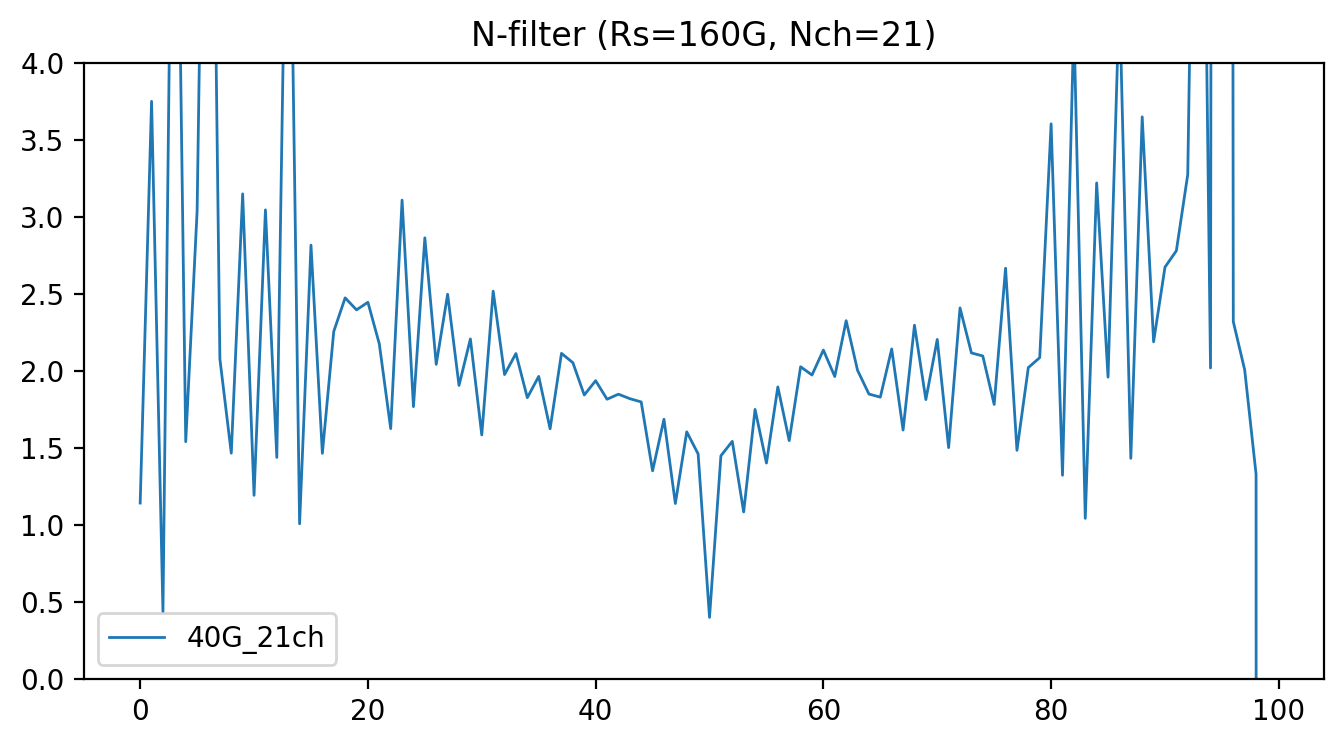

In [28]:
plt.figure(figsize=(8,4),dpi=200)
Rs, Nch = 160, 21
plt.title(f'N-filter (Rs={Rs}G, Nch={Nch})')

s,e = 350, 450
for key in ['40G_21ch']:
    plt.plot(kernels[key][0,0][s:e] / kernels[key][0,1][s:e], linewidth=1, label=key)
plt.legend()
plt.ylim(0, 4)

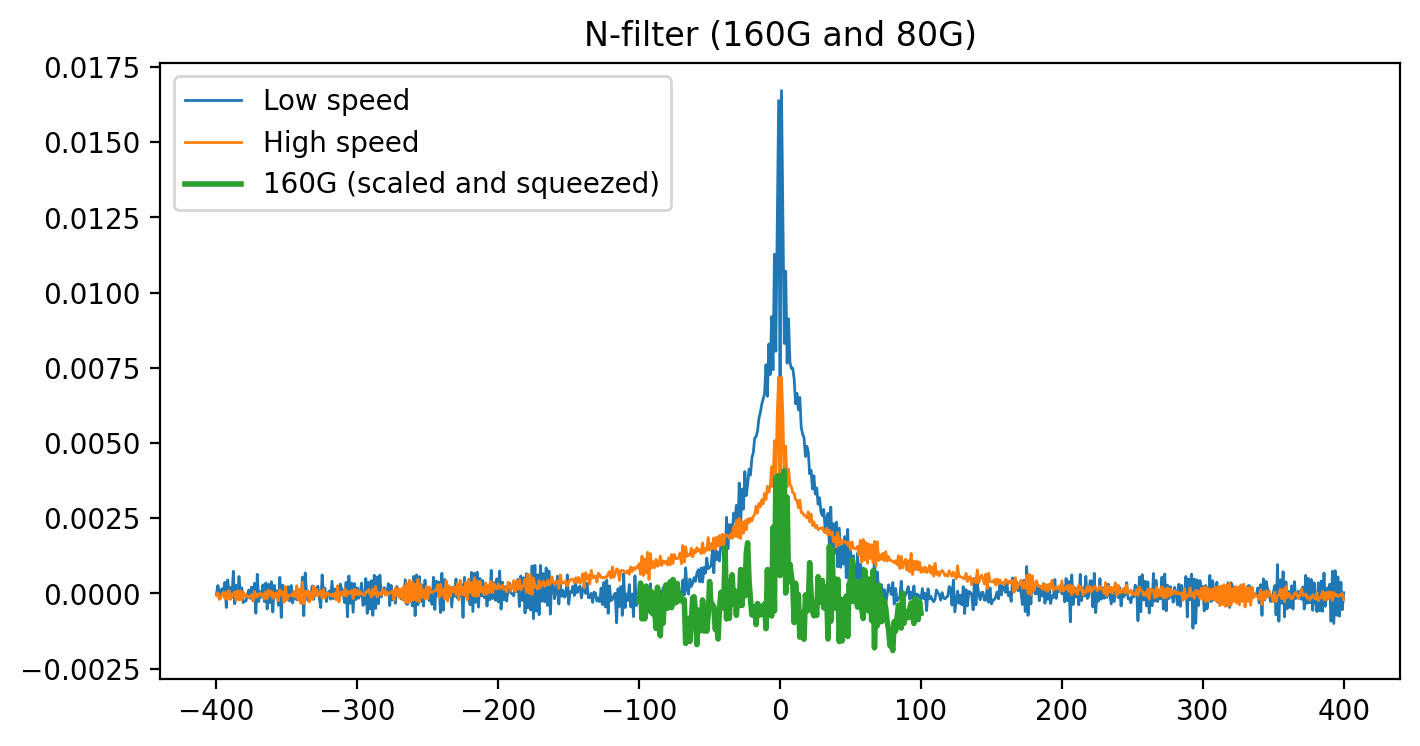

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4),dpi=200)
Rs, Nch = 80, 21
plt.title(f'N-filter (160G and 80G)')

kernels = [torch.load(f'_outputs/kernel_801/{key}.pt') for key in ['40G_21ch', '80G_21ch' ]]
x = np.arange(-400, 401)

plt.plot(x, kernels[0][1,1] , linewidth=1, label='Low speed')
plt.plot(x, kernels[1][1,1],  linewidth=1, label='High speed')
plt.plot(x[300:501], kernels[1][1,1][0::4] * 4 - kernels[0][1,1][300:501], linewidth=2, label='160G (scaled and squeezed)')
plt.legend(loc='upper left')

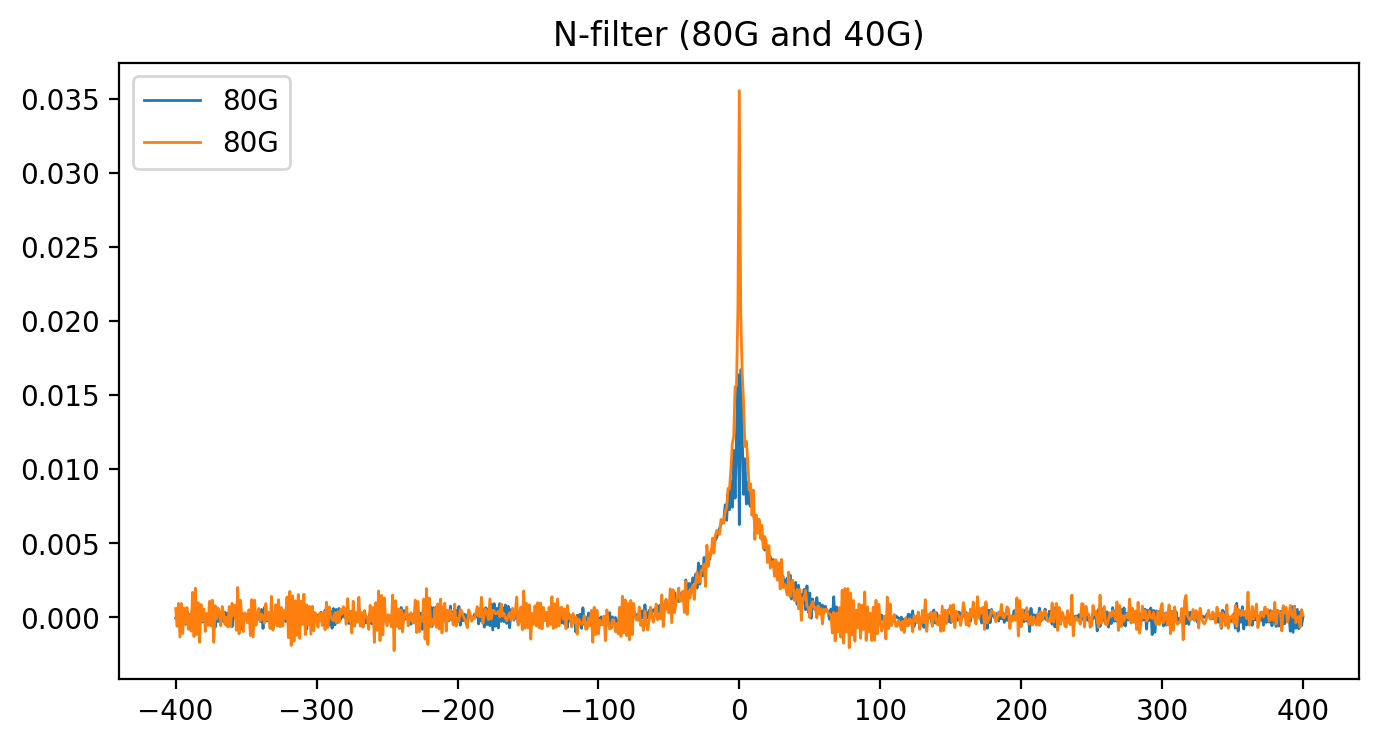

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4),dpi=200)
Rs, Nch = 80, 21
plt.title(f'N-filter (80G and 40G)')

def normalize(kernel):
    kernel = kernel - kernel.mean()
    return kernel / torch.mean(kernel**2)

kernels = [torch.load(f'_outputs/kernel_801/{key}.pt') for key in ['40G_21ch', '80G_21ch' ]]

x = np.arange(-400, 401)

# plt.plot(x, kernels[0][1,0] , linewidth=1, label='40G')
plt.plot(x, kernels[0][1,1],  linewidth=1, label='80G')
plt.plot(x, kernels[0][1,0]*2,  linewidth=1, label='80G')
# plt.plot(x[150:251], kernels[1][1,1][0::4] * 4, linewidth=2, label='80G (scaled and squeezed)')
plt.legend(loc='upper left')

In [ ]:
import matplotlib.pyplot as plt
plt.figure(dpi=200)
Rs, Nch = 80, 21

plt.title(f'N-filter (Rs={Rs}G, Nch={Nch})  (width=100)')
s,e = 380, 420
taps = 801
inp = torch.stack([torch.abs(torch.linspace(-1,1,taps))], dim=-1)
# plt.plot(net.task_mlp(inp)[:,0].data, label='N_xx (adf)')
# plt.plot(model.task_mlp(inp)[:,0].data[350:450], label='N_xy (adf)', linewidth=2)
plt.plot(kernels['40G_21ch'][0,0][s:e], '-o')
plt.plot(kernels['40G_21ch'][1,1][s:e], '-o')
plt.plot(kernels['80G_21ch'][0,0][s:e] , '-*')
plt.plot(kernels['80G_21ch'][1,1][s:e] , '-*')
plt.plot(kernels['160G_21ch'][0,0][s:e] , '-*')
plt.plot(kernels['160G_21ch'][1,1][s:e] , '-*')
# plt.plot(net.task_mlp(inp)[:,2].data, label='N_yx (adf)')
# plt.plot(net.task_mlp(inp)[:,3].data, label='N_yy (adf)')
plt.legend()

## show NewDBP Filter

In [10]:
import torch
import matplotlib.pyplot as plt
kernels = {key: torch.load(f'_outputs/kernel_801/{key}.pt') for key in ['40G_21ch','80G_11ch', '80G_21ch', '160G_21ch']}

dic = torch.load('_models/NewDBP/80G_21ch/30.pth')
model = LDBP(dic['dbp_info'])
model.load_state_dict(dic['dbp_param'])
# model = model.to('cuda:0')  

<All keys matched successfully>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


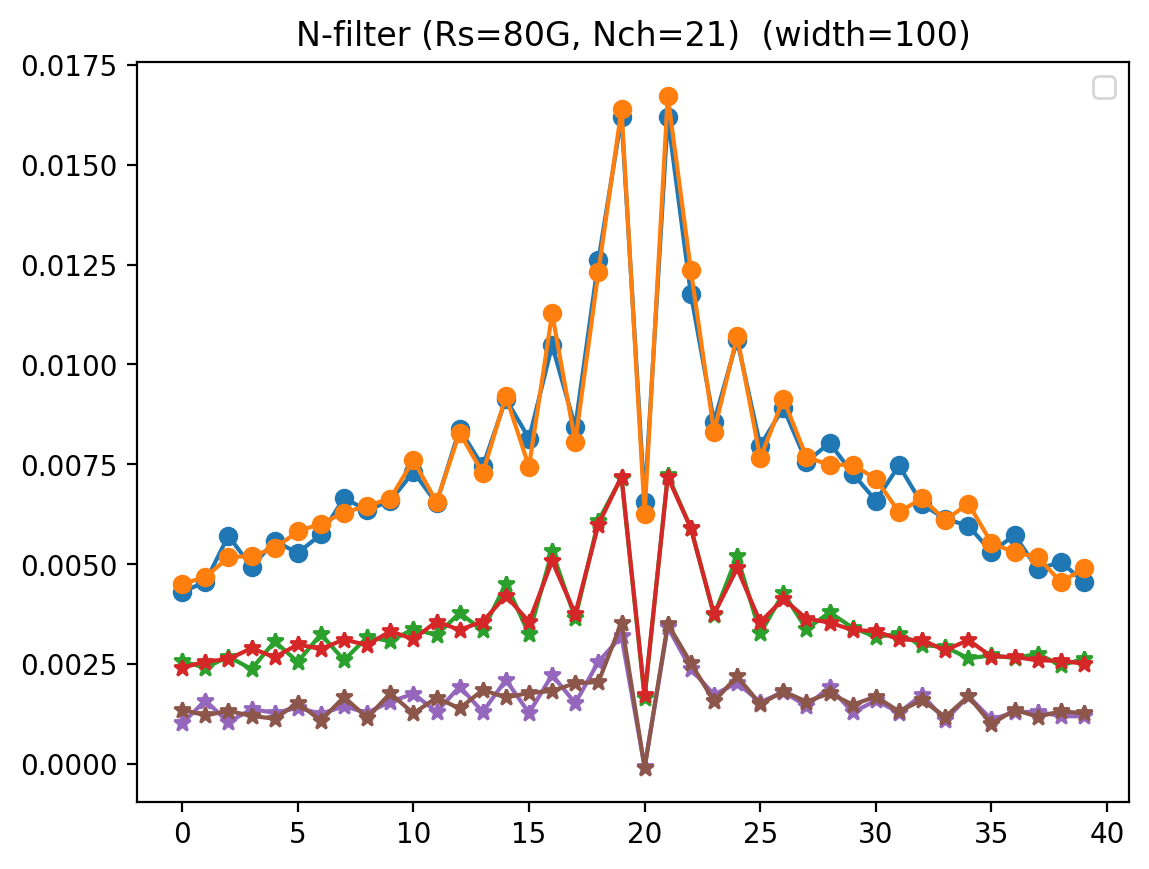

In [26]:
import matplotlib.pyplot as plt
plt.figure(dpi=200)
Rs, Nch = 80, 21

plt.title(f'N-filter (Rs={Rs}G, Nch={Nch})  (width=100)')
s,e = 380, 420
taps = 801
inp = torch.stack([torch.abs(torch.linspace(-1,1,taps))], dim=-1)
# plt.plot(net.task_mlp(inp)[:,0].data, label='N_xx (adf)')
# plt.plot(model.task_mlp(inp)[:,0].data[350:450], label='N_xy (adf)', linewidth=2)
plt.plot(kernels['40G_21ch'][0,0][s:e], '-o')
plt.plot(kernels['40G_21ch'][1,1][s:e], '-o')
plt.plot(kernels['80G_21ch'][0,0][s:e] , '-*')
plt.plot(kernels['80G_21ch'][1,1][s:e] , '-*')
plt.plot(kernels['160G_21ch'][0,0][s:e] , '-*')
plt.plot(kernels['160G_21ch'][1,1][s:e] , '-*')
# plt.plot(net.task_mlp(inp)[:,2].data, label='N_yx (adf)')
# plt.plot(net.task_mlp(inp)[:,3].data, label='N_yy (adf)')
plt.legend()

## show MetaDBP filter

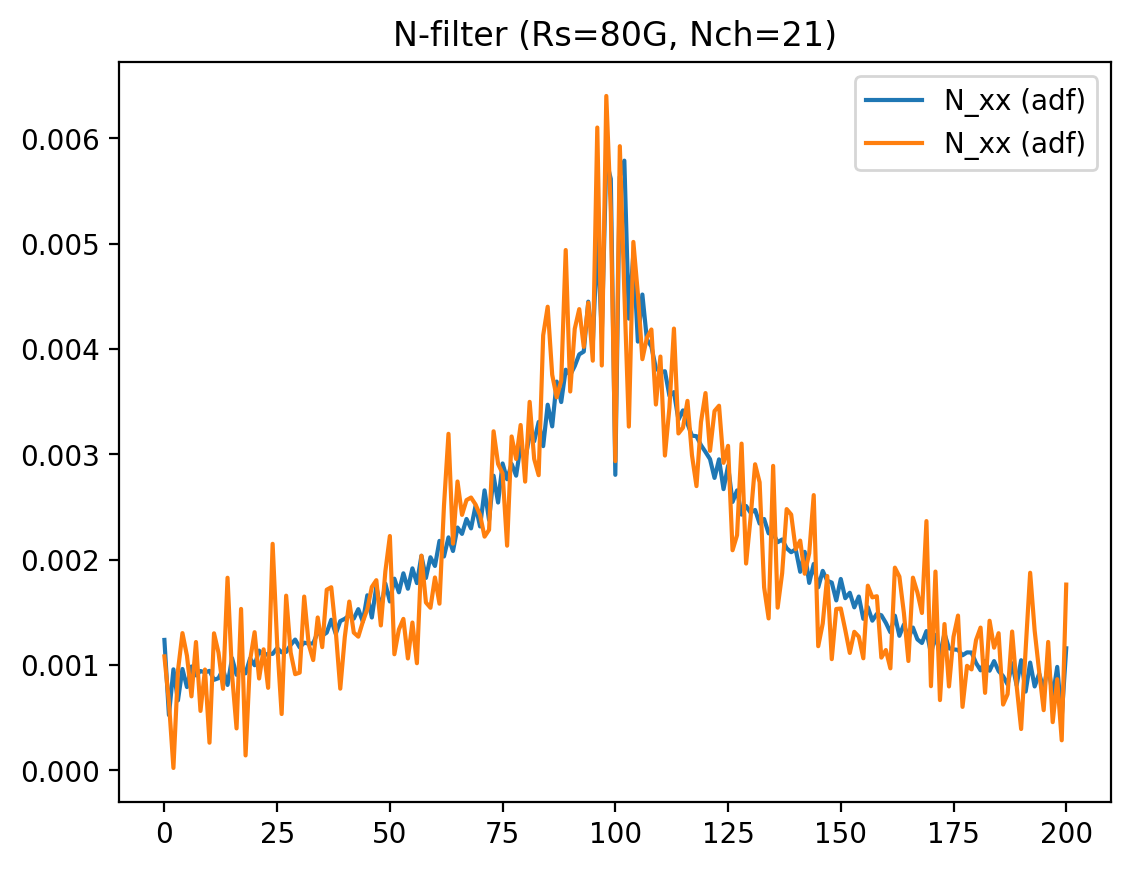

In [49]:

import matplotlib.pyplot as plt
plt.figure(dpi=200)
Rs, Nch = 80, 21

plt.title(f'N-filter (Rs={Rs}G, Nch={Nch})')

net.to('cpu')
plt.plot(net.task_mlp(torch.tensor([2, 0, 160e9, 21])).reshape(2,2,201)[1,1].cpu().data, label='N_xx (adf)')
plt.plot(net.task_mlp(torch.tensor([2, 0, 120e9, 21])).reshape(2,2,201)[1,1].cpu().data, label='N_xx (adf)')

plt.legend()